In [1]:
import fcsparser
import numpy as np
import os
import pandas as pd

In [2]:
def make_dir(path):
    '''Creates the directory path'''
    if not os.path.exists(path):
        os.makedirs(path)
    
def listFiles(directory, extension):
    '''
    Equivalent to:
    Files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                Files.append(file)
    '''
    files = [file for root, dirs, files in os.walk(directory) for file in files if file.endswith(extension)]
    print(extension + " files in " + directory + " listed")
    return files 

def fcs_to_csv(fcs_directory, csv_directory):
    '''
    Creates and saves the csv file associated with each file from fcs_directory to csv_directory
    '''
    
    files = listFiles(fcs_directory, '.fcs')
    
    for i in files:
        path = fcs_directory + i
        meta, data = fcsparser.parse(path, meta_data_only=False, reformat_meta=True)
        data.columns=['FSC-A','SSC-A','FL1-A','FL2-A','FL3-A','FL4-A','FSC-H','SSC-H','FL1-H','FL2-H','FL3-H','FL4-H','Width','Time']
        data.to_csv(csv_directory +'/'+ i[:-3]+'csv', index=False)
        
def merge_dfs(directory):
    
    files = listFiles(directory, '.csv')
    df = pd.read_csv(directory + files[0])
    
    for i in files[1:]:
        df1 = pd.read_csv(directory + i)
        df = df.append(df1)
    
    csv_dir_merged = './csv_data/Merged/'
    make_dir(csv_dir_merged)
    df.to_csv(csv_dir_merged +'mergedData'+'.csv',index=False)

In [3]:
fcs_dir = './fcs/'
csv_dir = './csv_data/Raw_csv'

#Creates the csv dir, converts fcs to csv and list the new csv files
make_dir(csv_dir)
fcs_to_csv(fcs_dir, csv_dir)
files_csv = listFiles(csv_dir, '.csv')

#defines dir
csv_cor_dir = './csv_data/Corrected_csv/'

#creates dir
make_dir(csv_cor_dir)
    
#create stats df
columns = ['label', 'n_events', 'mFSC-H', 'stdFSC-H', 'mFL3-A', 'stdFL3-A']
index = [i for i in range(len(files_csv))]
stats_df = pd.DataFrame(columns=columns, index = index)

#for each csv file
for j in range(len(files_csv)):
    
    #creates a dataframe
    df = pd.read_csv(csv_dir+'/'+ files_csv[j])
    ind = []
    
    #for each line of the dataFrame
    for i in range(len(df)):
        
        #Apply the filter and stores the indices
        if df['SSC-A'][i] == 0 or df['FL3-A'][i] < 800 or df['FSC-H'][i] < 11000:
            ind.append(i)
            
    #drop the lines corresponding to the indices and reset indices
    df = df.drop(df.index[ind])
    df = df.reset_index(drop=True)
    #the name of the new DataFrame consists of the first three letters (cell label)
    df['name'] = files_csv[j][0:3]
    
    #Makes statistics and creates a column with the results
    n_events = len(df)
    sigmasqH = np.std(df['FSC-H'].tolist())
    promH = np.mean(df['FSC-H'].tolist())
    sigmasq3 = np.std(df['FL3-A'].tolist())
    prom3 = np.mean(df['FL3-A'].tolist())
    
    #Save the csv with the filter and statistics
    df.to_csv(csv_cor_dir  +files_csv[j][0:3]+'.csv',index=False)
    print('File ' + str(j+1) + ' out of ' + str(len(files_csv)) + ' Done')    
    stats_df.loc[j] = [files_csv[j][0:3], n_events, promH, sigmasqH, prom3, sigmasq3]
    
#Statistics saved in statistics.csv
stats_df = stats_df.sort_values('label')
stats_df = stats_df.reset_index(drop=True)
csv_stat_dir = './csv_data/Statistics_csv/'
make_dir(csv_stat_dir)
stats_df.to_csv(csv_stat_dir + 'statistics'+'.csv', index = False)

#Merges all the csv_dataframes
merge_dfs(csv_cor_dir)

.fcs files in ./fcs/ listed
.csv files in ./csv_data/Raw_csv listed
File 1 out of 52 Done
File 2 out of 52 Done
File 3 out of 52 Done
File 4 out of 52 Done
File 5 out of 52 Done
File 6 out of 52 Done
File 7 out of 52 Done
File 8 out of 52 Done
File 9 out of 52 Done
File 10 out of 52 Done
File 11 out of 52 Done
File 12 out of 52 Done
File 13 out of 52 Done
File 14 out of 52 Done
File 15 out of 52 Done
File 16 out of 52 Done
File 17 out of 52 Done
File 18 out of 52 Done
File 19 out of 52 Done
File 20 out of 52 Done
File 21 out of 52 Done
File 22 out of 52 Done
File 23 out of 52 Done
File 24 out of 52 Done
File 25 out of 52 Done
File 26 out of 52 Done
File 27 out of 52 Done
File 28 out of 52 Done
File 29 out of 52 Done
File 30 out of 52 Done
File 31 out of 52 Done
File 32 out of 52 Done
File 33 out of 52 Done
File 34 out of 52 Done
File 35 out of 52 Done
File 36 out of 52 Done
File 37 out of 52 Done
File 38 out of 52 Done
File 39 out of 52 Done
File 40 out of 52 Done
File 41 out of 52 Don

In [143]:
# PLOT STATISTICS
%pylab inline
import seaborn as sns
'''
A (1-11) Calibration 14 Sep. Find specifications (I think the number of events was fixed)
C (1-11) Calibration 17 Sep, V 5uL  Fast
D (1-11) Calibration 17 Sep, V 10ul Fast
E (2-11) Calibration 17 Sep, V 5uL  Slow
F (2-11) Calibration 17 Sep, V 10ul Slow
'''
stats_df = pd.read_csv(csv_stat_dir + 'statistics.csv')

def subset_stats(criteria):
    stats_subset = pd.DataFrame(columns=stats_df.columns)
    for i in range(len(stats_df)):
        if(stats_df.loc[i]['label'].startswith(criteria)):
            stats_subset = stats_subset.append(stats_df.loc[i])
    stats_subset = stats_subset.reset_index(drop=True)
    return stats_subset

stats_A = subset_stats('A')
stats_C = subset_stats('C')
stats_D = subset_stats('D')
stats_E = subset_stats('E')
stats_F = subset_stats('F')

stats_A.columns

Populating the interactive namespace from numpy and matplotlib


Index(['label', 'n_events', 'mFSC-H', 'stdFSC-H', 'mFL3-A', 'stdFL3-A'], dtype='object')

Densities


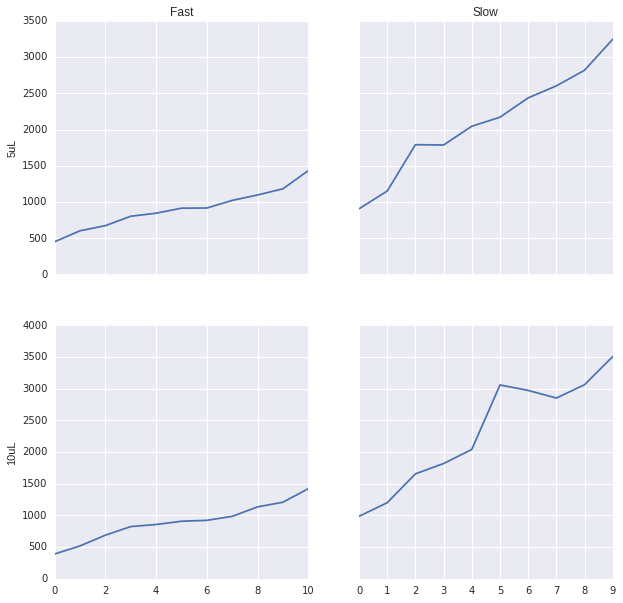

In [146]:
def compare_density_plots():
    
    fig, ax = plt.subplots(2,2,figsize = (10,10), sharex = 'col', sharey = 'row')

    ax[0,0].plot(stats_C['n_events']/5.0, label='C')

    ax[0,0].set_ylabel("5uL")
    ax[0,0].set_title("Fast")

    ax[0,1].plot(stats_E['n_events']/5.0, label='E')
    ax[0,1].set_title("Slow")

    ax[1,0].plot(stats_D['n_events']/10.0)
    ax[1,0].set_ylabel("10uL")
    ax[1,1].plot(stats_F['n_events']/10.0)
    
    plt.show()
    plt.close()

print("Densities")    
compare_density_plots()

mFSC-H


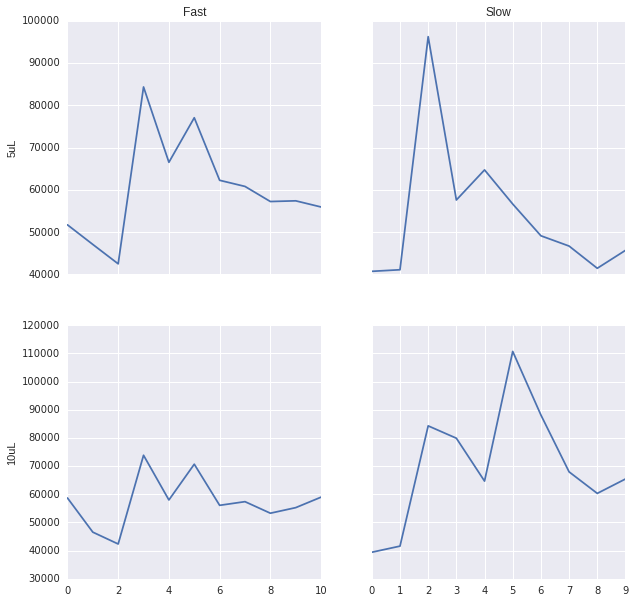

mFL3-A


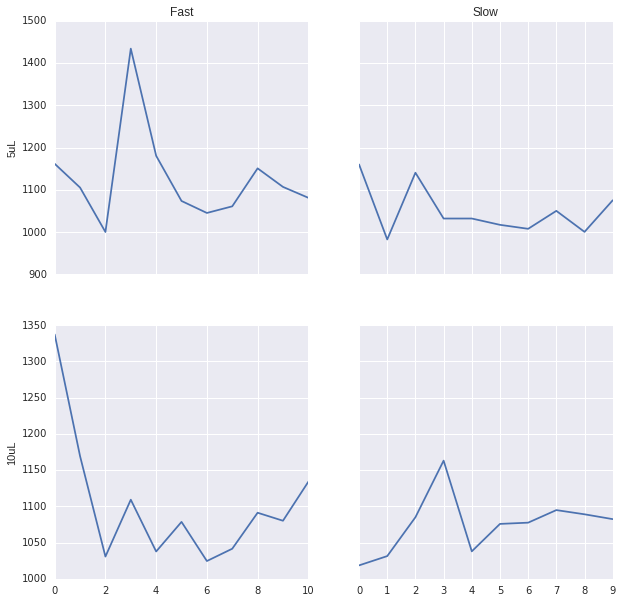

In [144]:
def compare_mode_plots(variable):

    fig, ax = plt.subplots(2,2,figsize = (10,10), sharex = 'col', sharey = 'row')

    ax[0,0].plot(stats_C[variable], label='C')

    ax[0,0].set_ylabel("5uL")
    ax[0,0].set_title("Fast")

    ax[0,1].plot(stats_E[variable], label='E')
    ax[0,1].set_title("Slow")

    ax[1,0].plot(stats_D[variable])
    ax[1,0].set_ylabel("10uL")
    ax[1,1].plot(stats_F[variable])
    
    plt.show()
    plt.close()

print("mFSC-H")
compare_mode_plots('mFSC-H')

print("mFL3-A")
compare_mode_plots('mFL3-A')

eta_FSC-H


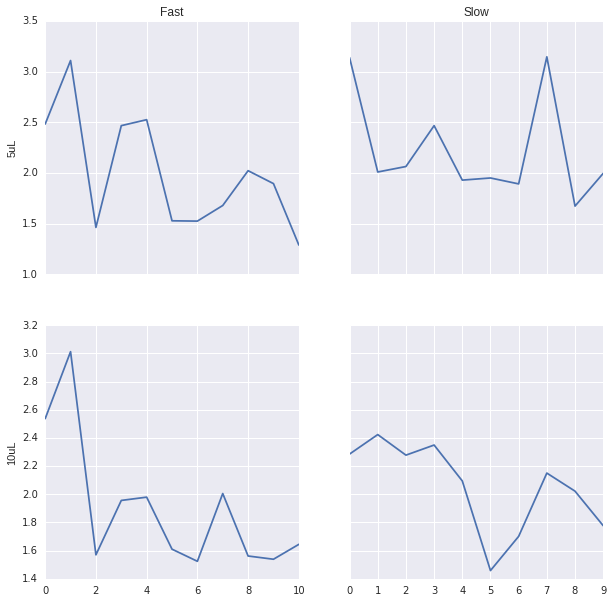

eta_FL3-A


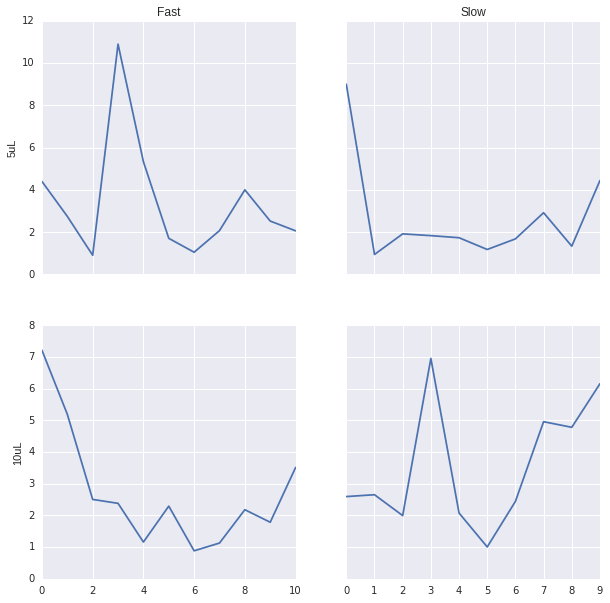

In [137]:
def compare_noise_plots(num, den):
    
    fig, ax = plt.subplots(2,2,figsize = (10,10), sharex = 'col', sharey = 'row')

    ax[0,0].plot(stats_C[num]/stats_C[den], label='C')

    ax[0,0].set_ylabel("5uL")
    ax[0,0].set_title("Fast")

    ax[0,1].plot(stats_E[num]/stats_E[den], label='E')
    ax[0,1].set_title("Slow")

    ax[1,0].plot(stats_D[num]/stats_D[den])
    ax[1,0].set_ylabel("10uL")
    ax[1,1].plot(stats_F[num]/stats_F[den])

    plt.show()
    plt.close()
     
print("eta_FSC-H")    
compare_noise_plots('stdFSC-H','mFSC-H')
    
print("eta_FL3-A")
compare_noise_plots('stdFL3-A','mFL3-A')


nu_FSC-H


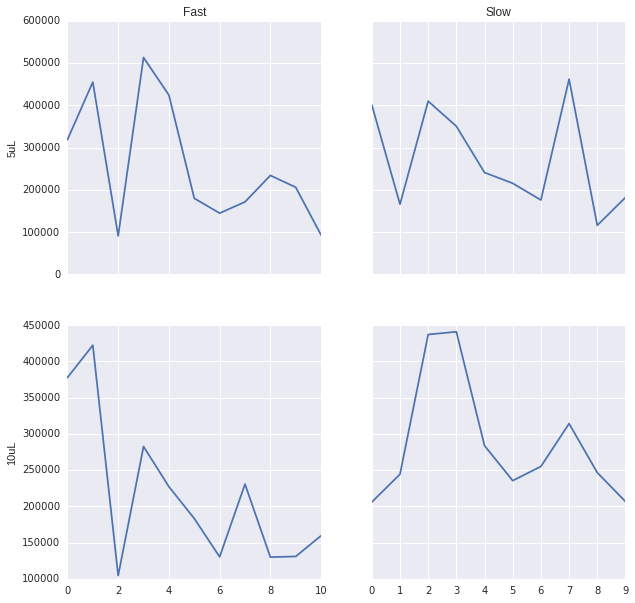

nu_FL3-A


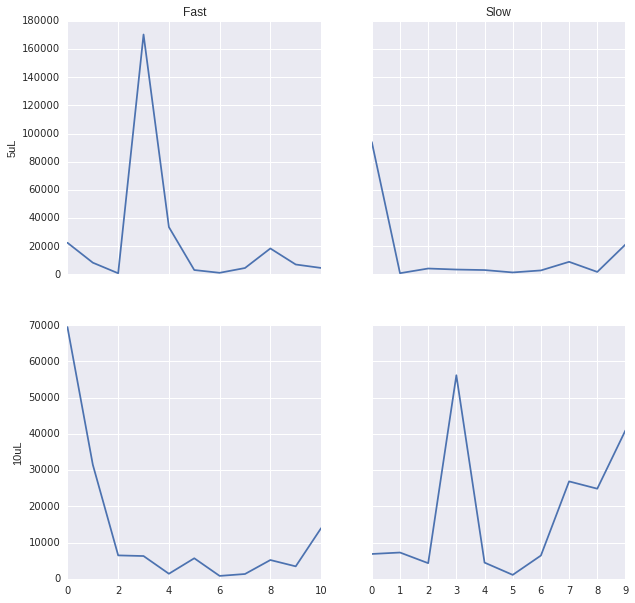

In [141]:
def compare_fano_plots(num, den):
    
    fig, ax = plt.subplots(2,2,figsize = (10,10), sharex = 'col', sharey = 'row')

    ax[0,0].plot(stats_C[num]**2/stats_C[den], label='C')

    ax[0,0].set_ylabel("5uL")
    ax[0,0].set_title("Fast")

    ax[0,1].plot(stats_E[num]**2/stats_E[den], label='E')
    ax[0,1].set_title("Slow")

    ax[1,0].plot(stats_D[num]**2/stats_D[den])
    ax[1,0].set_ylabel("10uL")
    ax[1,1].plot(stats_F[num]**2/stats_F[den])

    plt.show()
    plt.close()
     
print("nu_FSC-H")    
compare_fano_plots('stdFSC-H','mFSC-H')
    
print("nu_FL3-A")
compare_fano_plots('stdFL3-A','mFL3-A')


In [ ]:
for file in files:
    df = pd.read_csv(csv_correc+file)
    g = sns.jointplot(x = 'FSC-H' ,y = 'FL3-A' ,data = df)
    g.savefig(file+".png")
    plt.clf()